### Import required packages, set some settings

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

### Generate regression dataset

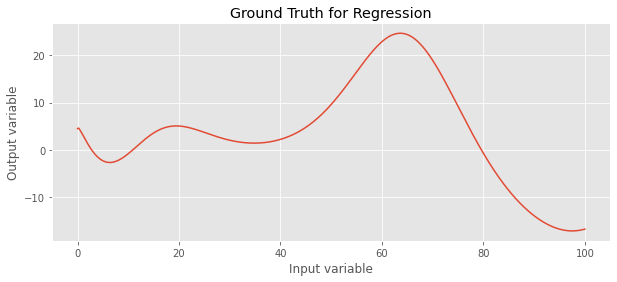

In [6]:
def ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.001*x+0.02)) + 3*np.exp(0.5*np.sin((x**0.9-3)/5))/((x+0.01)**(-0.5)) -0.005*x**2

xs = np.linspace(0, 100, 500)
ys = ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

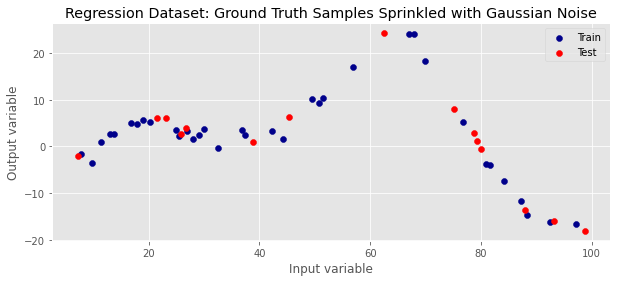

In [7]:
def generate_dataset(size=50, noise=1, split=0.3):
    xs = np.random.uniform(0, 100, size)
    ys = ground_truth(xs) + np.random.normal(0, noise, size)
    return train_test_split(xs, ys, test_size=split, random_state=13)

x_tr, x_te, y_tr, y_te = generate_dataset()
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

### Control test: deterministic MLP

##### Build model

In [8]:
class MLP(nn.Module):
    """Represents a multilayer perceptron"""
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),
            nn.ELU(),
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Linear(100, 1),
        )
    
    def forward(self, x):
        """Propagates x forward through the network"""
        return self.layers(x)

model = MLP()

loss = nn.MSELoss()
opt = torch.optim.SGD(
    model.parameters(), 
    lr=0.00005,  # learning rate
)

print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)


##### Train model

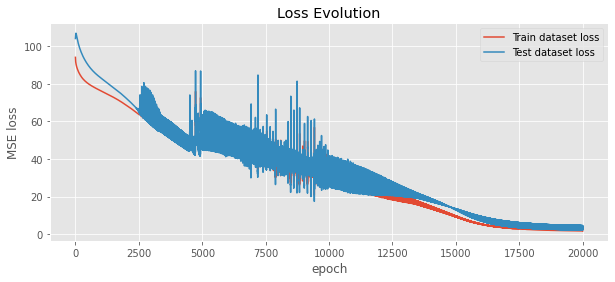

In [9]:
tr_loss_evo = []
te_loss_evo = []

for _ in range(20000):  # epochs
    y_tr_pred = model(x_tr)
    l = loss(y_tr_pred, y_tr)
    tr_loss_evo.append(l.item())
    te_loss_evo.append(loss(model(x_te), y_te).item())
    model.zero_grad()
    l.backward()
    opt.step()

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

##### Test model

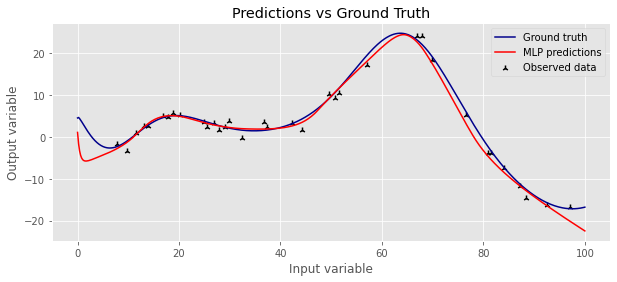

In [10]:
xs = np.linspace(0, 100, 500)
yps = model(torch.FloatTensor(xs).unsqueeze(-1)).detach().numpy()
ys = ground_truth(xs)
plt.title("Predictions vs Ground Truth")
plt.plot(xs, ys, color='darkblue', label='Ground truth')
plt.plot(xs, yps, color='red', label='MLP predictions')
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

### Bayesian neural network

##### Theory & assumptions

- The neural network is a function that returns an output given the input and the model parameters, $$\hat{y} = f(x, \boldsymbol{\theta})$$
- In our probabilistic setting, we assume a Gaussian likelihood: $$\mathcal{L}(\boldsymbol{\theta}) = p(\mathcal{D}|\boldsymbol{\theta}) = \prod_n\mathcal{N}(y_n|f(x_n,\boldsymbol{\theta}), \sigma^2_{noise})$$ where $\sigma_{noise}$ is a parameter which will be optimised during training

- We take independent Gaussian priors over the parameters, $$p(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta}|\boldsymbol{0}, \sigma_p^2\mathbf{I})$$ where $\sigma_p$ is a variance hyperparameter. Note that in the implementation below we take $\sigma_p = 1$
- Since the network function is highly nonlinear, the true posterior distribution is intractable and so we resort to variational inference. Namely, we resort to a mean-field (diagonal) Gaussian variational distribution: $$q_\phi(\boldsymbol{\theta}) = \prod_{i=1}^{|\boldsymbol{\theta}|}\mathcal{N}(\theta_i|\mu_i, \sigma_i^2)$$ where $\phi = \{\mu_i, \sigma_i\}$ are the variational parameters
- As usual in variational inference, we wish to select the variational parameters by minimising the Kullback-Leibler (KL) divergence between the variational distribution and the posterior, however as usual this too is intractable and so we optimise the evidence lower-bound (ELBO) instead, which can be written as: $$ELBO = \mathbb{E}_{\theta\sim q_{\phi}}[\log\mathcal{L}(\boldsymbol{\theta})] - KL[q_{\phi}||p(\boldsymbol{\theta})]$$ Looking at the two terms, we see that maximising the ELBO maximises the expected log likelihood (fit to the data) while minimising the KL divergence between the variational distribution and the prior distribution (the standard Bayesian "Occam's Razor" tradeoff)
- Since both the variational and prior distributions are taken to be Gaussian, the KL divergence between them can be calculated in closed form. Taking $k$ to denote the number of parameters, $$KL[q_{\phi}||p(\boldsymbol{\theta})] = \frac{1}{2}\sum_i^k[\frac{\mu_i^2 + \sigma_i^2}{\sigma_p^2} - 2\log\frac{\sigma_i}{\sigma_p} - 1]$$ Note that in the implementation below we use a PyTorch method to calculate the KL divergence, which of course uses this equation *under the hood*
- Unfortunately we cannot evaluate the first term in the ELBO directly, but we can estimate it by taking samples from the log likelihood and taking the sample mean. This would stop us from being able to propagate gradients through the network which we need in order to train it, but fortunately we can use the *reparameterisation trick* (Kingma and Welling, 2013. "Auto-Encoding Variational Bayes"): $$\boldsymbol{\theta} = \boldsymbol{\mu} + \boldsymbol{\sigma}\odot\boldsymbol{\epsilon}$$  $$\boldsymbol{\epsilon} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$$ $$\begin{aligned}\mathbb{E}_{\theta\sim q_{\phi}}[\log\mathcal{L}(\boldsymbol{\theta})] &= \log\mathcal{L}(\log\mathcal{L}(\boldsymbol{\mu} + \boldsymbol{\sigma}\odot\boldsymbol{\epsilon})] \\ &\approx \frac{1}{L}\sum^L_{l=1}\log\mathcal{L}(\boldsymbol{\mu} + \boldsymbol{\sigma}\odot\boldsymbol{\epsilon}^{(l)}) \end{aligned}$$ where $\boldsymbol{\epsilon}^{(l)} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$, $L$ is the number of samples used to estimate the expectation, and $\odot$ denotes the element-wise product

##### Build model

In [11]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-4):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.zeros(input_dim, output_dim)
        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.zeros(output_dim)

        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior.

        Args:
            x (torch.Tensor): Inputs to this layer.

        Returns:
            torch.Tensor: Outputs of this layer.
        """
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        return x @ weights + biases # (num_samples, batch_size, output_dim).








class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
        num_samples=1
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.noise_std = nn.Parameter(torch.tensor(noise_std), requires_grad=True)
        self.num_samples = num_samples

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i]))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim)
                )
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i])
                )
                self.network.append(self.activation) 

    def forward(self, x):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(self.num_samples, 1, 1)

        # Propagate x through network
        for i, layer in enumerate(self.network):
            x = layer(x)
            # if i < len(self.network) - 1:
            #     x = self.activation(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, self.noise_std)
        return l.log_prob(y_obs.unsqueeze(0).repeat(self.num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, y_pred, y):
        """Computes the ELBO and returns its negative"""
        
        exp_ll = self.ll(y, y_pred)
        # print('expll', exp_ll.shape)
        kl = self.kl()
        # print('kl', kl.shape)

        return kl - exp_ll

In [12]:
bnn_model = MeanFieldBNN(1, [100, 100, 100, 100], 1, num_samples=1)
print(bnn_model)

opt = torch.optim.SGD(
    bnn_model.parameters(),
    lr = 0.0008
)

MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
    (5): ELU(alpha=1.0)
    (6): MeanFieldLayer()
    (7): ELU(alpha=1.0)
    (8): MeanFieldLayer()
  )
)


##### Train model

epoch:  0
epoch:  500
epoch:  1000
epoch:  1500
epoch:  2000
epoch:  2500
epoch:  3000
epoch:  3500
epoch:  4000
epoch:  4500
epoch:  5000
epoch:  5500
epoch:  6000
epoch:  6500
epoch:  7000
epoch:  7500
epoch:  8000
epoch:  8500
epoch:  9000
epoch:  9500
epoch:  10000
epoch:  10500
epoch:  11000
epoch:  11500
epoch:  12000
epoch:  12500
epoch:  13000
epoch:  13500
epoch:  14000
epoch:  14500
epoch:  15000
epoch:  15500
epoch:  16000
epoch:  16500
epoch:  17000


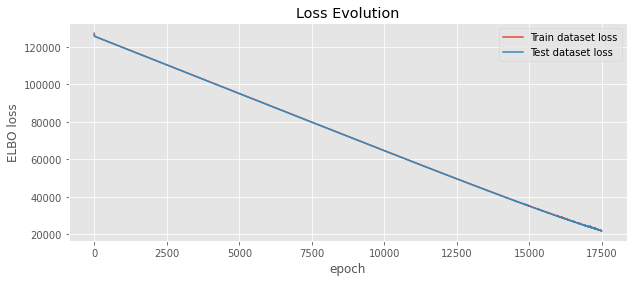

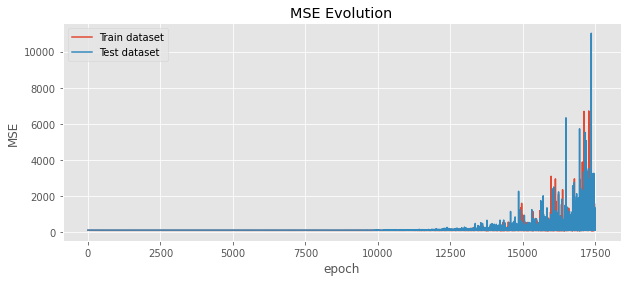

In [13]:
tr_loss_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in range(17500):  # epochs
    if epoch % 500 == 0:
        print('epoch: ', epoch)
    bnn_model.zero_grad()

    y_tr_pred = bnn_model(x_tr)
    l = bnn_model.loss(y_tr_pred, y_tr)
    tr_loss_evo.append(l.item())
    tr_mse_loss_evo.append(aux_loss(y_tr_pred, y_tr.unsqueeze(0)).item())

    y_te_pred = bnn_model(x_te)
    te_loss_evo.append(bnn_model.loss(y_te_pred, y_te).item())
    te_mse_loss_evo.append(aux_loss(y_te_pred, y_te.unsqueeze(0)).item())

    l.backward()
    opt.step()

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

##### Test model

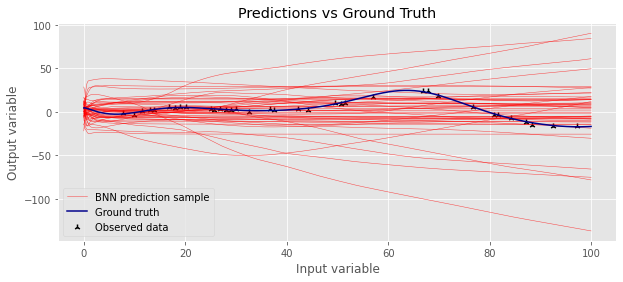

In [15]:
xs = np.linspace(0, 100, 500)
for j in range(50):
    pred_samples = bnn_model(torch.FloatTensor(xs).unsqueeze(-1)).detach().numpy()
    for i in range(pred_samples.shape[0]):
        if i == 0:
            plt.plot(xs, pred_samples[i,:,:], color='red', linewidth=0.5, alpha = 0.7)#, label='BNN prediction sample')
        else:
            plt.plot(xs, pred_samples[i,:,:], color='red', linewidth=0.5, alpha = 0.7)

plt.plot(xs, pred_samples[i,:,:], color='red', linewidth=0.5, alpha = 0.7, label='BNN prediction sample')

ys = ground_truth(xs)
plt.title("Predictions vs Ground Truth")
plt.plot(xs, ys, color='darkblue', label='Ground truth')
plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()